In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np

from wavhandler import *
from utils import *
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
sn.set()

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [2]:
df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')

# Creating dataframes that contain PSDs for each insect class

In [3]:
sz = 5000
df_an = make_df_parallel(df_mosquitos, setting='psd', insect_class='Anopheles', sample_size=sz).T
df_an['label'] = 'an'
df_ae = make_df_parallel(df_mosquitos, setting='psd',insect_class='Aedes', sample_size=sz).T
df_ae['label'] = 'ae'
df_cu = make_df_parallel(df_mosquitos, setting='psd',insect_class='Culex', sample_size=sz).T
df_cu['label'] = 'cu'

In [4]:
df_concat = pd.concat([df_ae, df_an, df_cu], axis=0, sort=False)
print(df_concat.shape)
df_concat.dropna(how='all', axis=1, inplace=True)
df_concat.dropna(how='any', axis=0, inplace=True)
print(df_concat.shape)
df_concat.head()
labelarray = df_concat.label.values
df_concat.drop('label', axis=1, inplace=True)
print(labelarray.shape)

(15000, 130)
(15000, 130)
(15000,)


### Example PSD

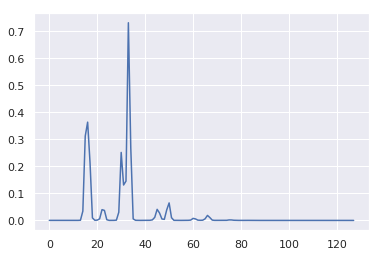

In [5]:
df_concat.iloc[9,:-1].plot()

# Loading the main dataframe created earlier to combine them both into one (merging on index)

In [6]:
df_mosquitos.drop(['names','pathlen','fnamelen','temp','humd','label2'], axis=1, inplace=True)
df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')
df_mosquitos.set_index('fname', inplace=True)
print(df_mosquitos.shape)
df_mosquitos.tail(10)

(167725, 16)


,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,names,pathlen,fnamelen,temp,humd,label1,label2
fname,,,,,,,,,,,,,,,,
F170301_193157_020_G_050_T_25.9_H_56.0,0.032887,0.093844,0.001396,810.546875,1625.000000,2425.781250,0.040964,0.009014,0.010870,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193314_029_G_050_T_25.9_H_56.0,0.122471,0.086202,0.002711,764.648438,1562.500000,2289.062500,0.031290,0.022187,0.009812,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193417_033_G_050_T_25.9_H_56.0,0.127117,0.042620,0.000739,787.109375,1582.031250,2305.664062,0.031638,0.010802,0.007412,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193421_034_G_050_T_25.9_H_56.0,0.038245,0.012146,0.000624,728.515625,1417.968750,2151.367188,0.038204,0.025826,0.006809,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193636_042_G_050_T_25.9_H_56.5,0.111496,0.092593,0.001553,544.921875,1102.539062,1555.664062,0.049283,0.011957,0.010986,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.5,Aedes,Ae. albopictus
F170301_193915_054_G_050_T_25.9_H_56.0,0.066598,0.136234,0.004561,527.343750,1052.734375,1562.500000,0.047222,0.027829,0.023750,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193916_055_G_050_T_25.9_H_56.0,0.113899,0.092764,0.032408,518.554688,1027.343750,1505.859375,0.048023,0.026141,0.020752,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_194005_064_G_050_T_25.9_H_56.0,0.082995,0.010639,0.001265,811.523438,1614.257812,2411.132812,0.044525,0.016939,0.012961,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_194043_070_G_050_T_25.9_H_56.5,0.096156,0.014383,0.001267,832.031250,1676.757812,2431.640625,0.036972,0.011066,0.007430,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.5,Aedes,Ae. albopictus


In [7]:
df = pd.merge(df_mosquitos, df_concat, left_index=True, right_index=True)
df.drop(['label1','label2','names','pathlen','fnamelen','humd','temp'], axis=1, inplace=True)
df.to_pickle('./data/big_df.pkl')

In [8]:
#df.read_pickle('./data/big_df.pkl')
df.head()

,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,0,...,119,120,121,122,123,124,125,126,127,128
F161205_161449_010_G_050,0.066777,0.128944,0.040860,558.593750,1105.468750,1657.226562,0.041084,0.020318,0.014437,0.000123,...,9.874663e-07,9.818351e-07,9.772683e-07,9.731258e-07,9.693112e-07,9.670397e-07,9.649247e-07,9.634711e-07,9.625892e-07,4.811501e-07
F161205_162304_042_G_050,0.098084,0.138478,0.014600,630.859375,1267.578125,1903.320312,0.034056,0.017334,0.011544,0.000109,...,8.621868e-07,8.593998e-07,8.531947e-07,8.506408e-07,8.480619e-07,8.461336e-07,8.442984e-07,8.431235e-07,8.424189e-07,4.210909e-07
F161205_162729_055_G_050,0.144476,0.059199,0.010514,642.578125,1268.554688,1901.367188,0.037234,0.031948,0.021828,0.000147,...,1.160178e-06,1.155139e-06,1.150880e-06,1.146031e-06,1.142344e-06,1.139574e-06,1.137274e-06,1.135634e-06,1.134674e-06,5.671760e-07
F161205_163713_082_G_050,0.163932,0.032717,0.000908,600.585938,1198.242188,1801.757812,0.036585,0.019560,0.014634,0.000085,...,3.444810e-07,3.434493e-07,3.423824e-07,3.413679e-07,3.405971e-07,3.399572e-07,3.394599e-07,3.391127e-07,3.389009e-07,1.694152e-07
F161205_163850_085_G_050,0.171476,0.035043,0.000582,663.085938,1327.148438,1985.351562,0.032401,0.016556,0.014265,0.000117,...,1.666158e-07,1.650851e-07,1.647291e-07,1.637336e-07,1.634132e-07,1.628967e-07,1.625685e-07,1.623198e-07,1.621740e-07,8.106261e-08


## SELECTING ONLY POWER AMPLITUDES

In [9]:
df = df_concat
cols = df.columns.tolist()
labels = labelarray
classes = np.unique(labelarray)
#df.label.value_counts()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
F170209_211825_188_G_050,0.000134,0.000160,0.000408,0.001423,0.001453,0.001436,0.001624,0.001110,0.000581,0.000414,...,9.826739e-07,9.810119e-07,9.759289e-07,9.726303e-07,9.695517e-07,9.673688e-07,9.655641e-07,9.642452e-07,9.634848e-07,4.816137e-07
F170209_154120_133_G_050,0.000213,0.000193,0.000077,0.000419,0.000416,0.000401,0.000370,0.000370,0.000430,0.000479,...,5.451259e-07,5.390289e-07,5.399119e-07,5.382444e-07,5.372369e-07,5.362149e-07,5.356022e-07,5.351005e-07,5.347995e-07,2.673503e-07
F170301_181000_023_G_050_T_25.9_H_51.6,0.000203,0.000225,0.003127,0.012594,0.018115,0.020897,0.011870,0.007358,0.004722,0.004087,...,1.210466e-06,1.209899e-06,1.199635e-06,1.196721e-06,1.192718e-06,1.189039e-06,1.186710e-06,1.184923e-06,1.183851e-06,5.917463e-07
F170213_091206_178_G_050,0.000146,0.000144,0.000373,0.001372,0.002359,0.001986,0.001543,0.001164,0.001252,0.001037,...,6.617204e-07,6.605357e-07,6.541999e-07,6.547377e-07,6.522939e-07,6.509256e-07,6.499020e-07,6.491537e-07,6.487073e-07,3.242771e-07
F170212_120440_107_G_050,0.000100,0.000097,0.000129,0.000752,0.000637,0.000326,0.000297,0.000291,0.000324,0.000338,...,1.071706e-06,1.069582e-06,1.066672e-06,1.062565e-06,1.059656e-06,1.057029e-06,1.055312e-06,1.053938e-06,1.053155e-06,5.264446e-07


In [10]:
df.index.shape

(15000,)

# Training a classifier

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

X, y = shuffle(df.values, labelarray, random_state=3)
#del df

"""
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=0)
ros.fit(X,y)
X, y = ros.fit_resample(X,y)
print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier = xgboost.XGBClassifier(n_estimators=650, learning_rate=0.2, n_jobs=-1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

Name: XGBoost, ac: 0.837333


## Feature importance

In [12]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                    index = df.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

,importance
3,0.029047
2,0.024755
16,0.016324
14,0.015251
19,0.014485
20,0.014408
12,0.013719
40,0.012876
13,0.012722
27,0.012492


### Saving the model

In [13]:
import pickle

pickle.dump(classifier, open("pima.pickle.dat", "wb"))
pd.Series(df.index).to_csv('pima_idx_used.csv')

# loaded_model = pickle.load(open("pima.pickle.dat", "rb"))

In [14]:
pd.DataFrame(X).to_csv('./unsupervised/mosquitos_test.csv')

# Confusion matrix

In [15]:
cm = confusion_matrix(y_test, y_pred)
len(labels)

15000

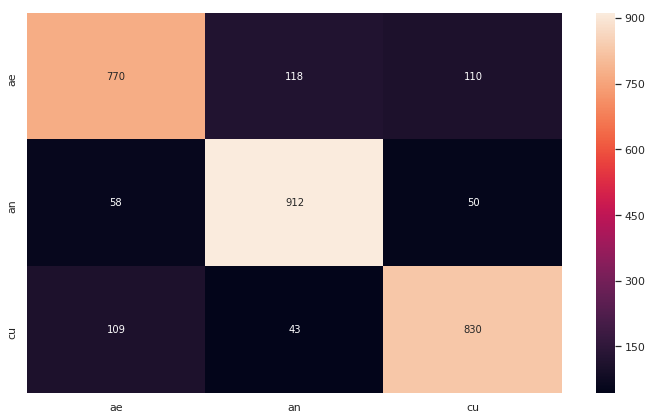

In [16]:
# Making a dataframe of the confusion matrix to plot it
df_cm = pd.DataFrame(cm, index=[i for i in classes], 
                    columns=[i for i in classes])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True, fmt='g')

plt.show()

## Distance Matrix

In [17]:
sub = np.concatenate((X, y.reshape(-1,1)), axis=1)
sub = pd.DataFrame(sub)
sub.sort_values(by=sub.iloc[:,-1].name, inplace=True)

In [18]:
sub.dropna(how='any', axis=0, inplace=True)


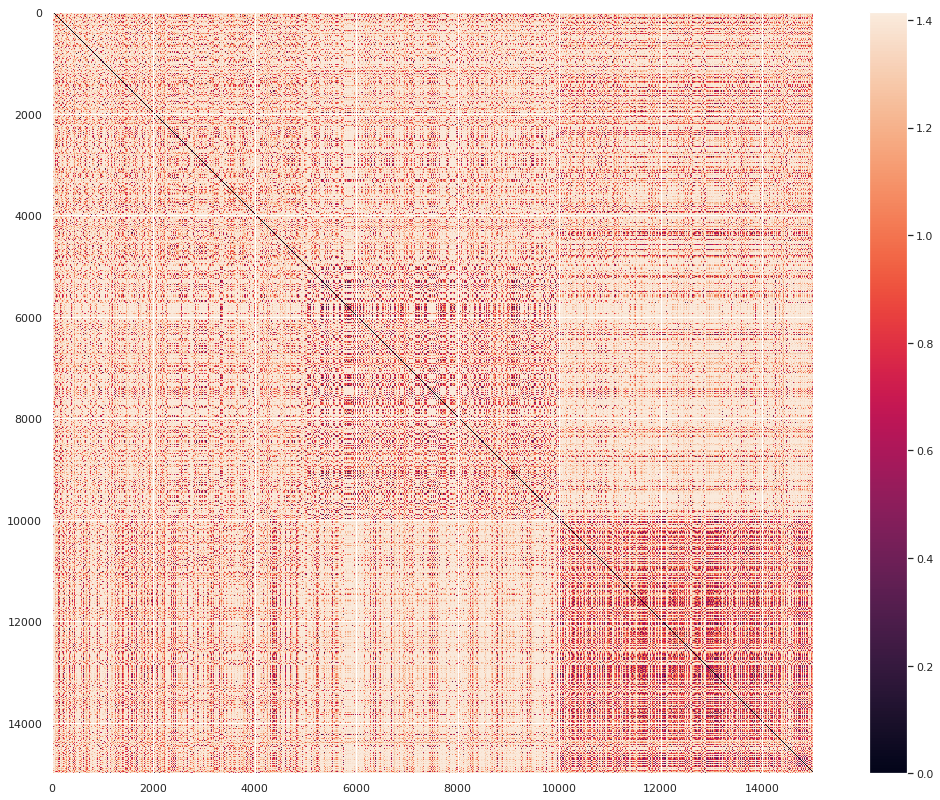

In [19]:
from scipy.spatial.distance import pdist, squareform
D = squareform(pdist(sub.values[:,:-1], metric='euclidean'))
#‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, 
#‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, 
#‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

plt.figure(figsize=(20,14))
plt.imshow(D)
plt.colorbar()

# Time warping

In [20]:
def find_median_signal(D=None):
    a = np.nanmedian(D, axis=0)
    minval = np.argmin(a[np.nonzero(a)])
    return minval # index - argmin

In [21]:
X = sub.values[:,:-1]

In [31]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

xx = X[50,:]
yy = X[13,:]

distance, path = fastdtw(xx, yy, dist=euclidean)
print(distance)

xx_idx = np.array([path[i][0] for i in range(len(path))])
yy_idx = np.array([path[i][1] for i in range(len(path))])

1.732030888248933


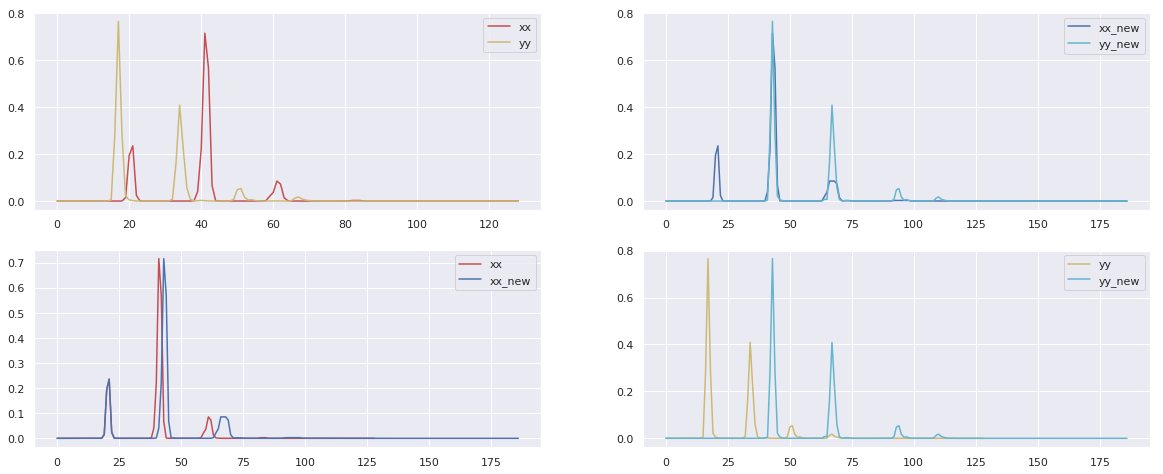

In [32]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(xx, c='r')
plt.plot(yy, c='y')
plt.legend(('xx','yy'))
#plt.ylim(0,0.15)

plt.subplot(2,2,2)
plt.plot(xx[xx_idx], c='b')
plt.plot(yy[yy_idx], c='c')
plt.legend(('xx_new','yy_new'))
#plt.ylim(0,0.15)

plt.subplot(2,2,3)
plt.plot(xx, c='r')
plt.plot(xx[xx_idx], c='b')
plt.legend(('xx','xx_new'))
#plt.ylim(0,0.15)

plt.subplot(2,2,4)
plt.plot(yy, c='y')
plt.plot(yy[yy_idx], c='c')
plt.legend(('yy','yy_new'))
#plt.ylim(0,0.15)

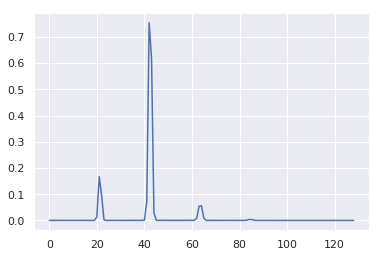

In [24]:
median_signal_idx = find_median_signal(D=X.astype(float))
median_signal = X[median_signal_idx,:]
plt.plot(median_signal)

In [37]:
#X.shape

D_dtw = np.zeros((600,600))

def warp_with_median_signal(xx, median_signal, distance=euclidean):
    _, path = fastdtw(xx, median_signal, dist=distance)
    
    idx = np.array([path[i][0] for i in range(len(path))])
    sig = xx[idx]
    
    return sig[:128]

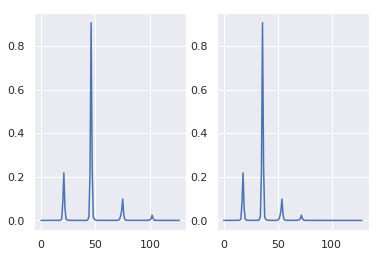

In [38]:
sig = X[10,:]
plt.subplot(1,2,1)
plt.plot(warp_with_median_signal(sig, median_signal, distance=euclidean))
#plt.xlim(0,2500)

plt.subplot(1,2,2)
plt.plot(sig)
#plt.xlim(0,2500)

In [39]:
from tqdm import tqdm

XX = []
for i in tqdm(range(X.shape[0])):
    XX.append(warp_with_median_signal(X[i,:], median_signal, distance=euclidean))

100%|██████████| 15000/15000 [07:52<00:00, 31.72it/s]


In [40]:
len(XX[2])

128

In [41]:
XX = np.vstack(XX)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

X, y = shuffle(XX, y, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier = xgboost.XGBClassifier(n_estimators=300, n_jobs=-1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

Name: XGBoost, ac: 0.339667


In [43]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[337, 325, 369],
       [304, 329, 370],
       [292, 321, 353]])